# Analysis

The breakdown of spectra into the Cartesian components, as well as decomposing to occupied MOs is discussed in the [X-ray section](../tutorials/xray_analysis). The study of excited states using natural transition orbitals and detachment/attachment densities are currently in the [visualization section](../visualize/exc_vis), and here we will now focus on using [OrbitalViewer](sec:orbview) and decomposition of eigenstates.

In [2]:
import copy

import gator
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI

comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386


def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "GNU".


First, we calculate the six lowest states of methanol using ADC(2):

In [4]:
ch3oh_mol_str = '''
C       0.6627602692    -0.0195253241    -0.0000000000
O      -0.7482324502     0.1217146925     0.0000000000
H       1.0282229693    -0.5397922417    -0.8872632580
H       1.0282229693    -0.5397922417     0.8872632580
H       1.0781531801     0.9835591659    -0.0000000000
H      -1.1253011321    -0.7605402778     0.0000000000
'''

# Construct structure and basis objects
struct = gator.get_molecule(ch3oh_mol_str)
basis = gator.get_molecular_basis(struct, "6-31G")

# Perform SCF calculation
scf_gs = gator.run_scf(struct, basis)

# Calculate the 6 lowest eigenstates
adc_res = gator.run_adc(struct, basis, scf_gs, method="adc2", singlets=6)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
         

## Print and plot spectra

Resulting eigenstates can be summarized with `describe()`:

In [5]:
print(adc_res.describe())

+--------------------------------------------------------------+
| adc2                                    singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     0.2941737      8.004874   0.0000    0.9527   0.04731  |
|  1     0.3742267      10.18323   0.0109    0.9533   0.04671  |
|  2     0.3841365      10.45289   0.0868    0.9329   0.06713  |
|  3      0.409496      11.14295   0.0005    0.9455   0.05445  |
|  4     0.4328735      11.77909   0.1071    0.9252   0.07478  |
|  5     0.4348448      11.83273   0.0266    0.9439   0.05607  |
+--------------------------------------------------------------+



And plotted with built-in functionalities, and here we also plot the state number next to each state to simplify analysis (note indexing from 0):

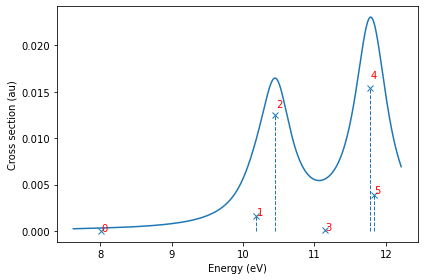

In [27]:
plt.figure(figsize=(6,4))
adc_res.plot_spectrum()
for i in np.arange(len(adc_res.excitation_energy)):
    plt.text(au2ev*adc_res.excitation_energy[i]+0.01,adc_res.oscillator_strength[i]/6.5,str(i),color='r')
plt.tight_layout()
plt.show()

## Dominant contributions to eigenstates

With `describe_amplitudes` we can study the dominant contributions of the states:

In [29]:
print(adc_res.describe_amplitudes())

+-------------------------------------------------------+
| State   0 ,     0.2941737 au,      8.004874 eV        |
+-------------------------------------------------------+
| HOMO            -> LUMO             a ->a      -0.652 |
| HOMO -3         -> LUMO             a ->a      -0.153 |
| HOMO            -> LUMO +1          a ->a      -0.146 |
| HOMO -3         -> LUMO +1          a ->a     -0.0575 |
| HOMO            -> LUMO +8          a ->a     +0.0233 |
| HOMO -3         -> LUMO +4          a ->a     -0.0232 |
| HOMO            -> LUMO+15          a ->a     +0.0206 |
| HOMO            -> LUMO+10          a ->a     +0.0196 |
| HOMO            -> LUMO+12          a ->a     +0.0175 |
| HOMO            -> LUMO +7          a ->a     +0.0165 |
| HOMO            -> LUMO +2          a ->a     +0.0105 |
| HOMO -4 HOMO    -> LUMO +4 LUMO     ab->ab    -0.0157 |
| HOMO    HOMO    -> LUMO    LUMO+13  ab->ab     +0.014 |
| HOMO -4 HOMO    -> LUMO    LUMO     ab->ab    -0.0139 |
| HOMO -2 HOMO

This outputs a string with all transitions and all contributions with an absolute value of 0.01. The printing threshold can be changed, as can the format of the output, but for now we focus on narrowing down on the two strongest state (2 and 4). This can be done by splitting the string at double line-breaks, where we also include a higher tolerance of inclusion of 0.1:

In [37]:
split_res = adc_res.describe_amplitudes(tolerance=0.1).split('\n\n')

Printing the dominant amplitudes of states 2 and 4:

In [48]:
print(split_res[2])
print('\n')
print(split_res[4])

+---------------------------------------------------+
| State   2 ,     0.3841365 au,      10.45289 eV    |
+---------------------------------------------------+
| HOMO          -> LUMO+1         a ->a       +0.64 |
| HOMO          -> LUMO           a ->a      -0.152 |
| HOMO          -> LUMO+2         a ->a       -0.11 |


+---------------------------------------------------+
| State   4 ,     0.4328735 au,      11.77909 eV    |
+---------------------------------------------------+
| HOMO          -> LUMO+3         a ->a      +0.652 |
| HOMO-3        -> LUMO+3         a ->a      +0.119 |


We see that both these excitations are dominate by transitions from HOMO to LUMO+1 and LUMO+3, and from `describe()` above we note that the transitions are dominated by singly excited configurations ($|v^2|^2\sim0.07$). 

## Visualizing molecular orbitals

Using OrbitalViewer, we can look at HOMO, LUMO+1, and LUMO+3:

In [50]:
viewer = vlx.OrbitalViewer()
viewer.plot(struct, basis, scf_gs.mol_orbs)

Output()

Dropdown(description='Orbital:', index=8, options=(('  1 occ=2.000 ene=-20.558', 0), ('  2 occ=2.000 ene=-11.2…

And we obtain:

```{figure} ../../img/uv_vis/uv-vis_mos.png
```

Using these MOs and above eigenstate contributions we can assign the features, provided that the excited states are relatively dominated by a few contributions, and the canonical MOs can be assigned. If this is not viable, we would instead turn to, *e.g.*, [natural transition orbitals](../visualize/exc_vis), where we obtain a compact description of the excited states.

## Polarization dependence

Finally, we can look at the Cartesian components of the transition dipole moments, to see how the excitation is polarized:

In [54]:
print('State 2:',adc_res.transition_dipole_moment[2])
print('State 4:',adc_res.transition_dipole_moment[4])

State 2: [ 2.94137281e-14 -2.17145638e-14 -5.82241208e-01]
State 4: [ 5.17627387e-01 -3.21072518e-01  3.42342958e-13]


- Visualization and assignment of states
    - Valence-valence
    - Valence-Rydberg
    - Charge-transfer
- Check visualization tools paper(s) for good examples
- Descriptors which help determine state character